<a href="https://colab.research.google.com/github/Ayouta5/CodeClause_Fake_News_Analysis/blob/main/FakeNewsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fake News Analysis**

# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import classification_report,accuracy_score

# Data collection and processing

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
df["merged"] = df["title"]+" "+df["author"]

In [7]:
df.head()

,id,title,author,text,label,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [8]:
df = df.dropna(axis=0)

In [9]:
count = np.unique(df['label'], return_counts=True)
count

(array([0, 1]), array([10361,  7924]))

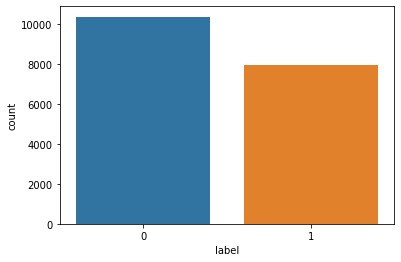

In [10]:
import seaborn as sns
sns.countplot(x='label', data = df)

In [11]:
Y = df['label']
X = df.drop('label', axis=1)

In [12]:
news = X.copy()

In [13]:
news['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [14]:
news.reset_index(inplace=True)

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [17]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(news)):
    review = re.sub('[^a-zA-Z]', ' ', news['merged'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop]
    review = ' '.join(review)
    corpus.append(review)

In [18]:
corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [19]:
voc_size = 5000
num = [one_hot(words, voc_size) for words in corpus]
num[0]

[1893, 3571, 3154, 1593, 1283, 2905, 341, 1487, 4253, 3242, 4583, 3489]

# Create Word Embeddings

In [20]:
sent_length = 20
embedded_news = pad_sequences(num, padding='pre', maxlen=sent_length)
print(embedded_news[0])

[   0    0    0    0    0    0    0    0 1893 3571 3154 1593 1283 2905
  341 1487 4253 3242 4583 3489]


# Creating a Model

In [21]:
embedding_vector_features = 50
model = Sequential([
    Embedding(voc_size, embedding_vector_features, input_length=sent_length),
    LSTM(100),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            250000    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
x_final = np.array(embedded_news)
y_final = np.array(Y)

# Splitting into Training data and Test Data

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42)

# Model Training

In [24]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256)

Epoch 1/5
65/65 [==============================] - 9s 104ms/step - loss: 0.4139 - accuracy: 0.7982 - val_loss: 0.1646 - val_accuracy: 0.9366
Epoch 2/5
65/65 [==============================] - 6s 97ms/step - loss: 0.0767 - accuracy: 0.9744 - val_loss: 0.0602 - val_accuracy: 0.9770
Epoch 3/5
65/65 [==============================] - 6s 92ms/step - loss: 0.0269 - accuracy: 0.9923 - val_loss: 0.0368 - val_accuracy: 0.9863
Epoch 4/5
65/65 [==============================] - 6s 91ms/step - loss: 0.0135 - accuracy: 0.9965 - val_loss: 0.0292 - val_accuracy: 0.9896
Epoch 5/5
65/65 [==============================] - 6s 95ms/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.0312 - val_accuracy: 0.9869


# Confusion Matrix

In [25]:
classes_x = (model.predict(X_test) > 0.5).astype("int32")

58/58 [==============================] - 1s 7ms/step


In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[1019,   17],
       [   7,  786]])